In [2]:
import TP_4_modulos
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def create_set(size = 10000):

    X, Y = TP_4_modulos.generate_dna_sequences(size)
    X = np.array([np.array(TP_4_modulos.one_hot_encoding(x)).flatten() for x in X])
    Y = torch.tensor(Y, dtype = torch.float32).reshape(-1, 1)
    X = torch.tensor(X)

    return X, Y

X, Y = create_set(5000) # 5000 seqs, size 1000 bp
X_test, Y_test = create_set(1000)

dataset = TensorDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

dataset_val = TensorDataset(X_test, Y_test)
dataloader_val = DataLoader(dataset_val, batch_size = 10, shuffle = False)

In [3]:
my_nn = nn.Sequential(
    nn.Linear(4000, 3),
    nn.ReLU(),
    nn.Linear(3, 3),
    nn.ReLU(),
    nn.Linear(3, 1),
    nn.Sigmoid())

LF = nn.BCELoss()

optimizer = optim.SGD(my_nn.parameters(), lr=1e-3, weight_decay = 1e-4)

In [3]:
def train(network, optimizer, 
          criterion, 
          train_loader = None):
    
    network.train()
    batch_size = train_loader.batch_size
    total_loss = 0

    for batch_i, (data, target) in enumerate(train_loader):

        
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
            
        
    avg_loss = total_loss / len(train_loader)
    return avg_loss


def test(network, criterion, valid_loader):
    
    network.eval()
    total_val_loss = 0
    batch_size = valid_loader.batch_size
    
    with torch.inference_mode():
        for batch_i, (data, target) in enumerate(valid_loader):
            output = network(data)
            val_loss = criterion(output, target)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(valid_loader)
    return avg_val_loss

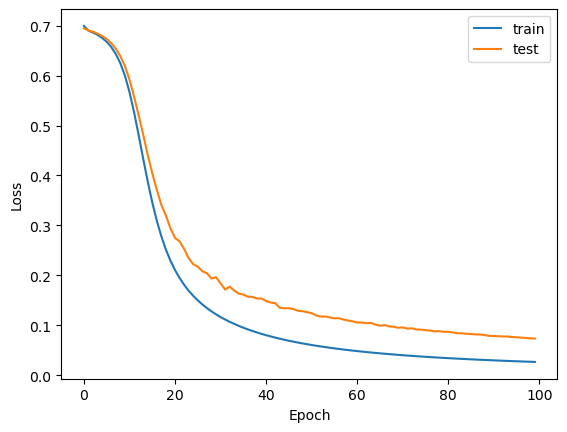

In [5]:
losses = []
losses_val = []
for epoch in range(100):
        
    avg_train_loss = train(my_nn, optimizer, LF, dataloader)
    avg_val_loss = test(my_nn, LF, dataloader_val)
    losses.append(avg_train_loss)
    losses_val.append(avg_val_loss)

plt.plot(losses, label = 'train')
plt.plot(losses_val, label = 'test')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
Y_hat = my_nn(X_test)

In [4]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(Y_test.detach(), Y_hat.detach())

NameError: name 'Y_test' is not defined

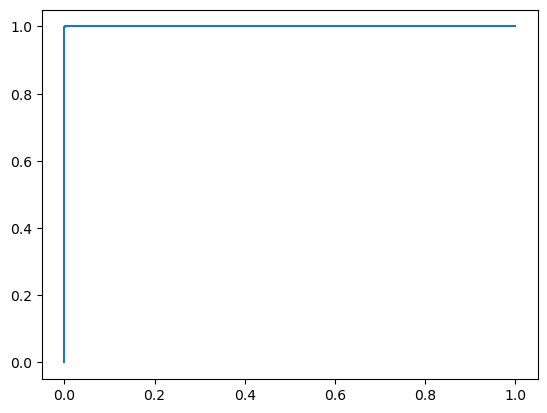

0.9999959989757378


In [8]:
plt.plot(fpr, tpr)
plt.show()
print(roc_auc_score(Y_test.detach(), Y_hat.detach()))

# Promoters prediction

## TN generation method: dinucleotide shuffle

In [5]:
promotores = TP_4_modulos.read_fasta_as_list('promotores.fasta')
promotores_one_hot = np.array([np.array(TP_4_modulos.one_hot_encoding(x)) for x in promotores])
random_seqs = np.array([TP_4_modulos.dinucleotide_shuffle(x).flatten() for x in promotores_one_hot])
X = np.array([x.flatten() for x in promotores_one_hot])
X_neg = np.array([x.flatten() for x in random_seqs])
X = np.vstack([X, X_neg])
Y = np.array([1 for _ in range(1870)] + [0 for _ in range(1870)])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15)

y_train = torch.tensor(y_train, dtype = torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test, dtype = torch.float32).reshape(-1, 1)
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)

dataset = TensorDataset(X_train, y_train)
dataset_val = TensorDataset(X_test, y_test) 
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=10, shuffle=False)

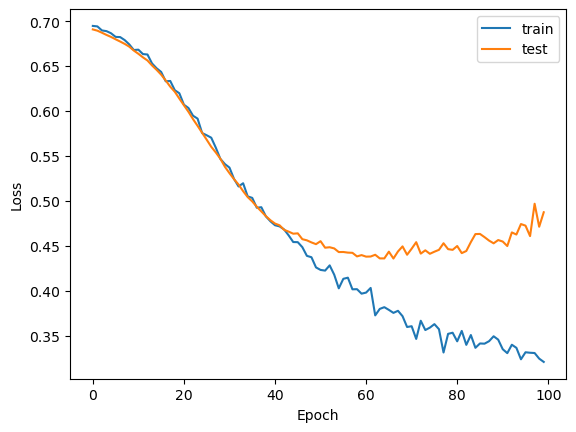

In [10]:
my_nn = nn.Sequential(
    nn.Linear(2400, 3),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(3, 5),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(5, 1),
    nn.Sigmoid())

LF = nn.BCELoss()

optimizer = optim.SGD(my_nn.parameters(), lr=1e-3, weight_decay = 1e-3)

losses = []
losses_val = []
for epoch in range(100):
        
    avg_train_loss = train(my_nn, optimizer, LF, dataloader)
    avg_val_loss = test(my_nn, LF, dataloader_val)
    losses.append(avg_train_loss)
    losses_val.append(avg_val_loss)

plt.plot(losses, label = 'train')
plt.plot(losses_val, label = 'test')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

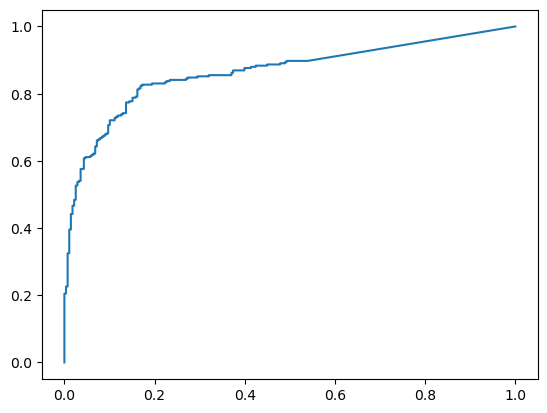

0.864453313674149


In [11]:
Y_hat = my_nn(X_test)
fpr, tpr, thresholds = roc_curve(y_test.detach(), Y_hat.detach())
plt.plot(fpr, tpr)
plt.show()
print(roc_auc_score(y_test.detach(), Y_hat.detach()))

## TN generation method: random mutations

In [6]:
random_seqs = np.array([TP_4_modulos.mutation(x, n_mutations=300).flatten() for x in promotores_one_hot])
X = np.array([x.flatten() for x in promotores_one_hot])
X_neg = np.array([x.flatten() for x in random_seqs])
X = np.vstack([X, X_neg])
Y = np.array([1 for _ in range(1870)] + [0 for _ in range(1870)])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15)

y_train = torch.tensor(y_train, dtype = torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test, dtype = torch.float32).reshape(-1, 1)
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)

dataset = TensorDataset(X_train, y_train)
dataset_val = TensorDataset(X_test, y_test) 
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=10, shuffle=False)

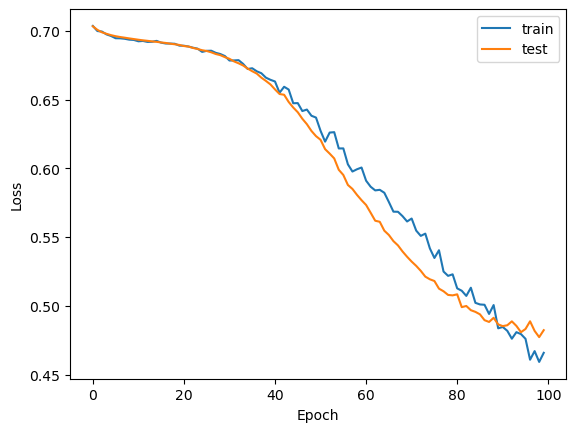

In [14]:
my_nn = nn.Sequential(
    nn.Linear(2400, 3),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(3, 5),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(5, 1),
    nn.Sigmoid())

LF = nn.BCELoss()

optimizer = optim.SGD(my_nn.parameters(), lr=1e-3, weight_decay = 1e-3)

losses = []
losses_val = []

for epoch in range(100):
        
    avg_train_loss = train(my_nn, optimizer, LF, dataloader)
    avg_val_loss = test(my_nn, LF, dataloader_val)
    losses.append(avg_train_loss)
    losses_val.append(avg_val_loss)

plt.plot(losses, label = 'train')
plt.plot(losses_val, label = 'test')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

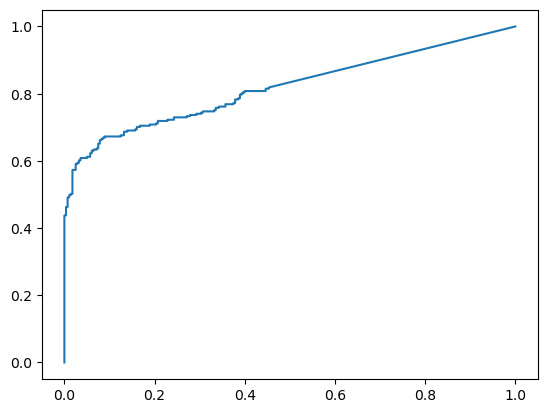

0.8183464667005593


In [15]:
Y_hat = my_nn(X_test)
fpr, tpr, thresholds = roc_curve(y_test.detach(), Y_hat.detach())
plt.plot(fpr, tpr)
plt.show()
print(roc_auc_score(y_test.detach(), Y_hat.detach()))

Con menos de 300 mutaciones funciona **bastante** mal

## Imbalanced dataset

In [20]:

def prepare_dataset(X, y, n_TP, n_TN, seed=None):

    if seed is not None:
        np.random.seed(seed)
    
    idx_pos = np.where(y == 1)[0]
    idx_neg = np.where(y == 0)[0]

    selected_pos = np.random.choice(idx_pos, n_TP, replace=False)
    selected_neg = np.random.choice(idx_neg, n_TN, replace=False)

    selected_idx = np.concatenate([selected_pos, selected_neg])
    np.random.shuffle(selected_idx)  # opcional, para mezclar

    X_out = X[selected_idx]
    y_out = y[selected_idx]

    return X_out, y_out

def prepare_dataloaders(X, Y):

    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15)

    y_train = torch.tensor(y_train, dtype = torch.float32).reshape(-1, 1)
    y_test = torch.tensor(y_test, dtype = torch.float32).reshape(-1, 1)
    X_train = torch.tensor(X_train)
    X_test = torch.tensor(X_test)

    dataset = TensorDataset(X_train, y_train)
    dataset_val = TensorDataset(X_test, y_test) 
    dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
    dataloader_val = DataLoader(dataset_val, batch_size=10, shuffle=False)

    return dataloader, dataloader_val, X_test, y_test

In [8]:
from sklearn.metrics import precision_recall_curve

In [35]:
all_train_losses = []
all_val_losses = []
all_precision = []
all_recall = []

random_seqs = np.array([TP_4_modulos.dinucleotide_shuffle(x).flatten() for x in promotores_one_hot])

X = np.array([x.flatten() for x in promotores_one_hot])
X_neg = np.array([x.flatten() for x in random_seqs])
X = np.vstack([X, X_neg])
Y = np.array([1 for _ in range(int(X.shape[0]/2))] + [0 for _ in range(int(X.shape[0]/2))])

X_dev, X_eval, y_dev, y_eval = train_test_split(X, Y, test_size=0.1)

for n_TP, n_TN in zip([1500, 1500, 15], [1500, 15, 1500]):

    X, Y = prepare_dataset(X_dev, y_dev, n_TP, n_TN)
    dataloader, dataloader_val, X_test, y_test = prepare_dataloaders(X, Y)

    my_nn = nn.Sequential(
        nn.Linear(2400, 3),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(3, 5),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(5, 1),
        nn.Sigmoid())

    LF = nn.BCELoss()

    optimizer = optim.SGD(my_nn.parameters(), lr=1e-3, weight_decay = 1e-3)

    losses = []
    losses_val = []

    for epoch in range(100):
            
        avg_train_loss = train(my_nn, optimizer, LF, dataloader)
        avg_val_loss = test(my_nn, LF, dataloader_val)
        losses.append(avg_train_loss)
        losses_val.append(avg_val_loss)

    all_train_losses.append(losses)
    all_val_losses.append(losses_val)

    # Precision-recall curve
    X_eval = torch.tensor(X_eval)
    y_eval = torch.tensor(y_eval, dtype = torch.float32).reshape(-1, 1)
    Y_hat = my_nn(X_eval)
    precision,recall, thresholds = precision_recall_curve(y_eval.detach(), Y_hat.detach())
    all_precision.append(precision)
    all_recall.append(recall)

    

/tmp/ipykernel_44130/1143600189.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_eval = torch.tensor(X_eval)
/tmp/ipykernel_44130/1143600189.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_eval = torch.tensor(y_eval, dtype = torch.float32).reshape(-1, 1)
/tmp/ipykernel_44130/1143600189.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_eval = torch.tensor(X_eval)
/tmp/ipykernel_44130/1143600189.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

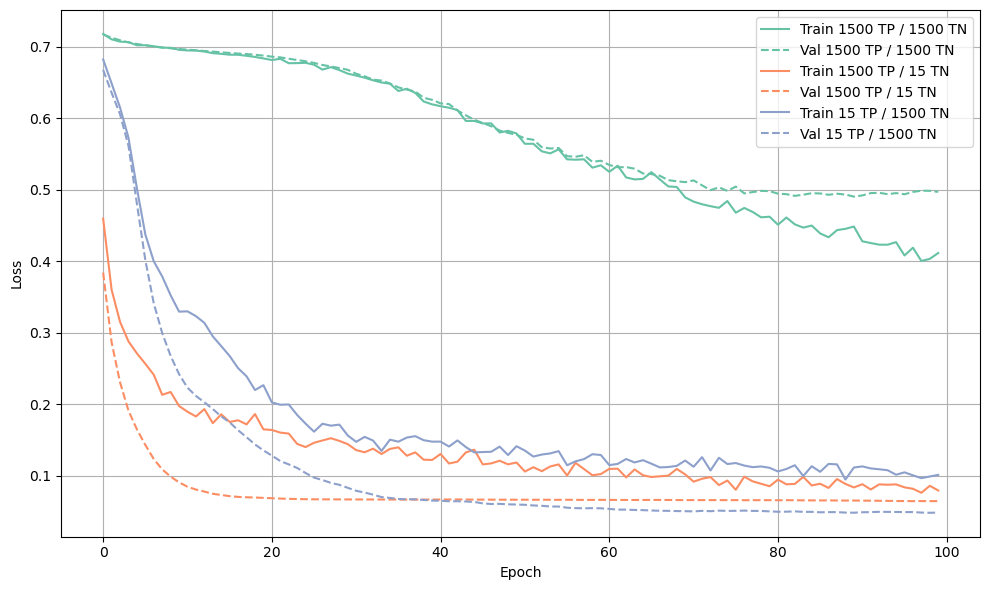

In [36]:
labels = ['1500 TP / 1500 TN', '1500 TP / 15 TN', '15 TP / 1500 TN']

colors = plt.get_cmap('Set2').colors  

plt.figure(figsize=(10, 6))

for i in range(3):
    plt.plot(all_train_losses[i], label=f'Train {labels[i]}', color=colors[i], linestyle='-')
    plt.plot(all_val_losses[i], label=f'Val {labels[i]}', color=colors[i], linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

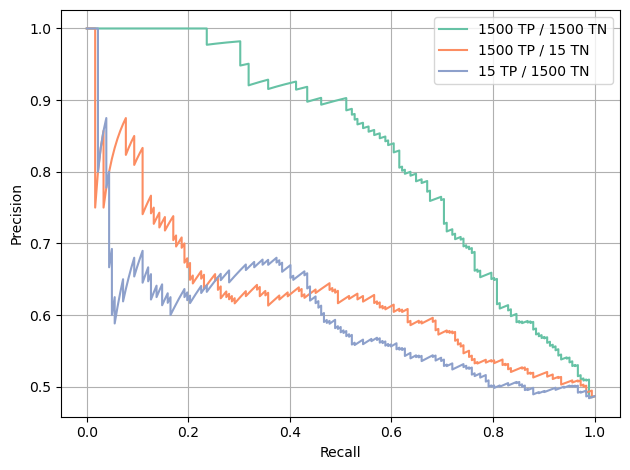

In [37]:
for i in range(3):
    plt.plot(all_recall[i], all_precision[i], label=f'{labels[i]}', color = colors[i])
    plt.legend()

plt.ylabel('Precision')
plt.xlabel('Recall')

plt.grid(True)
plt.tight_layout()
plt.show()